# Image-Text Matching Classifier: baseline system

This program has been adapted and rewritten from sources such as:
- [TensorFlow CNN Tutorial](https://www.tensorflow.org/tutorials/images/cnn)
- [Keras Concatenate Layer Documentation](https://keras.io/api/layers/merging_layers/concatenate/)
- [Sentence Transformers Package](https://pypi.org/project/sentence-transformers/)

If you are new to TensorFlow, read the following brief tutorial:
- [TensorFlow Quickstart Beginner Tutorial](https://www.tensorflow.org/tutorials/quickstart/beginner)

As you develop your experience and skills, you may want to check details of particular aspects of the TensorFlow API:
- [TensorFlow API Documentation](https://www.tensorflow.org/api_docs/python/tf/all_symbols)

This is a binary classifier for image-text matching, where the inputs are images and text-based features, and the outputs (denoted as match=[1,0] and nomatch=[0,1]) correspond to (predicted) answers. This baseline classifier makes use of two strands of features. The first are produced by a CNN-classifier, and the second are derived offline from a sentence embedding generator. The latter have the advantage of being generated once, which can accelerate training due to being pre-trained and loaded at runtime. Those two strands of features are concatenated at training time to form a multimodal set of features, combining learnt image features and pre-trained sentence features.

This program has been tested using an Anaconda environment with Python 3.9 and 3.10 on Windows 11 and Linux Ubuntu 22. The easiest way to run this baseline at Uni is by booting your PC with Windows and using the following steps:

1. Make sure that your downloaded data and baseline system are extracted in the Downloads folder. Note. Your path should start with /mnt/c/Users/Computing/Downloads

2. Open a terminal and select Ubuntu from the little arrow pointing down. Note. Your program will be executed under a Linux environment.

3. Install the following dependencies:

4. Edit file ITM_Classifier-baseline.py and make sure that variable IMAGES_PATH points to the right folder containing the data.

5. Run the program using a command such as


In [1]:
#$ python ITM_Classifier-baseline.py


The code above can also be run from Visual Studio Code. To access it using the Linux environment type "code ." in the Ubuntu terminal. From VSCode, click View, Terminal, type your command (example: python ITM_Classifier-baseline.py) and Enter.

Running this baseline takes about 5 minutes with a GPU-enabled Uni PC. WARNING: Running this code without a GPU is too slow and not recommended.

In your own PC you can use Anaconda to run this code. From a conda terminal for example. If you want GPU-enabled execution, it is recommended that you install the following versions of software:
- CUDA 11.8
- CuDNN 8.6
- TensorFlow 2.10

Feel free to use and/or modify this program as part of your CMP9137 assignment. You are invited to use the knowledge acquired during lectures, workshops and beyond to propose and evaluate alternative solutions to this baseline.

Version 1.0, main functionality tested with COCO data
Version 1.2, extended functionality for Flickr data
Contact: {hcuayahuitl, lzhang, friaz}@lincoln.ac.uk


In [7]:
# Let's import the dependencies

import sys
import os
import time
import einops
import pickle
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from official.nlp import optimization
import matplotlib.pyplot as plt

In [8]:
# Verify TensorFlow can detect the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if len(gpus) > 0:
    print(f"Using GPU: {gpus[0].device_type} {gpus[0].name}")
else:
    print("No GPU detected. Running on CPU.")

Num GPUs Available: 0
No GPU detected. Running on CPU.


In [4]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [ ]:
# Class for loading image and text data

class ITM_DataLoader():
    BATCH_SIZE = 16
    IMAGE_SIZE = (224, 224)
    IMAGE_SHAPE = (224, 224, 3)
    SENTENCE_EMBEDDING_SHAPE = (384)
    AUTOTUNE = tf.data.AUTOTUNE
    IMAGES_PATH = "/home/rinzler/Github/Image-Text-Matching/data/images"
    train_data_file = "/home/rinzler/Github/Image-Text-Matching/data/flickr8k.TrainImages.txt"
    dev_data_file = "/home/rinzler/Github/Image-Text-Matching/data/flickr8k.DevImages.txt"
    test_data_file = "/home/rinzler/Github/Image-Text-Matching/data/flickr8k.TestImages.txt"
    sentence_embeddings_file = "/home/rinzler/Github/Image-Text-Matching/data/flickr8k.cmp9137.sentence_transformers.pkl"
    sentence_embeddings = {}
    train_ds = None
    val_ds = None
    test_ds = None

    def __init__(self):
        self.sentence_embeddings = self.load_sentence_embeddings()
        self.train_ds = self.load_classifier_data(self.train_data_file)
        self.val_ds = self.load_classifier_data(self.dev_data_file)
        self.test_ds = self.load_classifier_data(self.test_data_file)
        print("done loading data...")

    # Sentence embeddings are dense vectors representing text data, one vector per sentence. 
    # Sentences with similar vectors would mean sentences with equivalent meanning.  
	# They are useful here to provide text-based features of questions in the data.
    # Note: sentence embeddings don't include label info, they are solely based on captions.
    def load_sentence_embeddings(self):
        sentence_embeddings = {}
        print("READING sentence embeddings...")
        with open(self.sentence_embeddings_file, 'rb') as f:
            data = pickle.load(f)
            for sentence, dense_vector in data.items():
                sentence_embeddings[sentence] = dense_vector
                #print("*sentence=",sentence)
        print("Done reading sentence_embeddings!")
        return sentence_embeddings

    # In contrast to text-data based on pre-trained features, image data does not use
    # any form of pre-training in this program. Instead, it makes use of raw pixels.
    # Notes that input features to the classifier are only pixels and sentence embeddings.
    def process_input(self, img_path, dense_vector, text, label):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, self.IMAGE_SIZE)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.cast(img, tf.float32) / 255
        features = {}
        features["image_input"] = img
        features["text_embedding"] = dense_vector
        features["caption"] = text
        features["file_name"] = img_path
        return features, label

    # This method loads the multimodal data, which comes from the following sources:
    # (1) image files in IMAGES_PATH, and (2) files with pattern flickr8k.*Images.txt
    # The data is stored in a tensorflow data structure to make it easy to use by
    # the tensorflow model during training, validation and test. This method was 
    # carefully prepared to load the data rapidly, i.e., by loading already created
    # sentence embeddings (text features) rather than creating them at runtime.
    def load_classifier_data(self, data_files):
        print("LOADING data from "+str(data_files))
        print("=========================================")
        image_data = []
        text_data = []
        embeddings_data = []
        label_data = []
		
        # get image, text, label of image_files
        with open(data_files) as f:
            lines = f.readlines()
            for line in lines:
                line = line.rstrip("\n")
                img_name, text, raw_label = line.split("	")
                img_name = os.path.join(self.IMAGES_PATH, img_name.strip())

                # get binary labels from match/no-match answers
                label = [1, 0] if raw_label == "match" else [0, 1]
                #print("I=%s T=%s _L=%s L=%s" % (img_name, text, raw_label, label)) 

				# get sentence embeddings (of textual captions)
                text_sentence_embedding = self.sentence_embeddings[text]
                text_sentence_embedding = tf.constant(text_sentence_embedding)

                image_data.append(img_name)
                embeddings_data.append(text_sentence_embedding)
                text_data.append(text)
                label_data.append(label)

        print("|image_data|="+str(len(image_data)))
        print("|text_data|="+str(len(text_data)))
        print("|label_data|="+str(len(label_data)))
		
        # prepare a tensorflow dataset using the lists generated above
        dataset = tf.data.Dataset.from_tensor_slices((image_data, embeddings_data, text_data, label_data))
        dataset = dataset.shuffle(self.BATCH_SIZE * 8)
        dataset = dataset.map(self.process_input, num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.batch(self.BATCH_SIZE).prefetch(self.AUTOTUNE)
        self.print_data_samples(dataset)
        return dataset

    def print_data_samples(self, dataset):
        print("PRINTING data samples...")
        print("-----------------------------------------")
        for features_batch, label_batch in dataset.take(1):
            for i in range(1):
                print(f'Image pixels: {features_batch["image_input"]}')
                print(f'Sentence embeddings: {features_batch["text_embedding"]}')
                print(f'Caption: {features_batch["caption"].numpy()}')
                label = label_batch.numpy()[i]
                print(f'Label : {label}')
        print("-----------------------------------------")

In [ ]:
# Main class for the Image-Text Matching (ITM) task

class ITM_Classifier(ITM_DataLoader):
    epochs = 10
    learning_rate = 3e-5
    class_names = {'match', 'no-match'}
    num_classes = len(class_names)
    classifier_model = None
    history = None
    classifier_model_name = 'ITM_Classifier-flickr'

    def __init__(self):
        super().__init__()
        self.build_classifier_model()
        self.train_classifier_model()
        self.test_classifier_model()

    # return learnt feature representations of input data (images)
    def create_vision_encoder(self, num_projection_layers, projection_dims, dropout_rate):
        img_input = layers.Input(shape=self.IMAGE_SHAPE, name="image_input")
        cnn_layer = layers.Conv2D(16, 3, padding='same', activation='relu')(img_input)
        cnn_layer = layers.MaxPooling2D()(cnn_layer)
        cnn_layer = layers.Conv2D(32, 3, padding='same', activation='relu')(cnn_layer)
        cnn_layer = layers.MaxPooling2D()(cnn_layer)
        cnn_layer = layers.Conv2D(64, 3, padding='same', activation='relu')(cnn_layer)
        cnn_layer = layers.MaxPooling2D()(cnn_layer)
        cnn_layer = layers.Dropout(dropout_rate)(cnn_layer)
        cnn_layer = layers.Flatten()(cnn_layer)
        outputs = self.project_embeddings(cnn_layer, num_projection_layers, projection_dims, dropout_rate)
        return img_input, outputs

    # return learnt feature representations based on dense layers, dropout, and layer normalisation
    def project_embeddings(self, embeddings, num_projection_layers, projection_dims, dropout_rate):
        projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
        for _ in range(num_projection_layers):
            x = tf.nn.gelu(projected_embeddings)
            x = layers.Dense(projection_dims)(x)
            x = layers.Dropout(dropout_rate)(x)
            x = layers.Add()([projected_embeddings, x])
            projected_embeddings = layers.LayerNormalization()(x)
        return projected_embeddings

    # return learnt feature representations of input data (text embeddings in the form of dense vectors)
    def create_text_encoder(self, num_projection_layers, projection_dims, dropout_rate):
        text_input = keras.Input(shape=self.SENTENCE_EMBEDDING_SHAPE, name='text_embedding')
        outputs = self.project_embeddings(text_input, num_projection_layers, projection_dims, dropout_rate)
        return text_input, outputs

    # put together the feature representations above to create the image-text (multimodal) deep learning model
    def build_classifier_model(self):
        print(f'BUILDING model')
        img_input, vision_net = self.create_vision_encoder(num_projection_layers=1, projection_dims=128, dropout_rate=0.1)
        text_input, text_net = self.create_text_encoder(num_projection_layers=1, projection_dims=128, dropout_rate=0.1)
        net = tf.keras.layers.Concatenate(axis=1)([vision_net, text_net])
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(self.num_classes, activation='softmax', name=self.classifier_model_name)(net)
        self.classifier_model = tf.keras.Model(inputs=[img_input, text_input], outputs=net)
        self.classifier_model.summary()
	
    def train_classifier_model(self):
        print(f'TRAINING model')
        steps_per_epoch = tf.data.experimental.cardinality(self.train_ds).numpy()
        num_train_steps = steps_per_epoch * self.epochs
        num_warmup_steps = int(0.2*num_train_steps)

        loss = tf.keras.losses.KLDivergence()
        metrics = tf.keras.metrics.BinaryAccuracy()
        optimizer = optimization.create_optimizer(init_lr=self.learning_rate,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

        self.classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        # uncomment the next line if you wish to make use of early stopping during training
        #callbacks = [tf.keras.callbacks.EarlyStopping(patience=11, restore_best_weights=True)]

        self.history = self.classifier_model.fit(x=self.train_ds, validation_data=self.val_ds, epochs=self.epochs)#, callbacks=callbacks)
        print("model trained!")

    def test_classifier_model(self):
        print("TESTING classifier model (showing a sample of image-text-matching predictions)...")
        num_classifications = 0
        num_correct_predictions = 0

        # read test data for ITM classification
        for features, groundtruth in self.test_ds:
            groundtruth = groundtruth.numpy()
            predictions = self.classifier_model(features)
            predictions = predictions.numpy()
            captions = features["caption"].numpy()
            file_names = features["file_name"].numpy()

            # read test data per batch
            for batch_index in range(0, len(groundtruth)):
                predicted_values = predictions[batch_index]
                probability_match = predicted_values[0]
                probability_nomatch = predicted_values[1]
                predicted_class = "[1 0]" if probability_match > probability_nomatch else "[0 1]"
                if str(groundtruth[batch_index]) == predicted_class: 
                    num_correct_predictions += 1
                num_classifications += 1

                # print a sample of predictions -- about 10% of all possible
                if random.random() < 0.1:
                    caption = captions[batch_index]
                    file_name = file_names[batch_index].decode("utf-8")
                    print("ITM=%s PREDICTIONS: match=%s, no-match=%s \t -> \t %s" % (caption, probability_match, probability_nomatch, file_name))

        # reveal test performance using our own calculations above
        accuracy = num_correct_predictions/num_classifications
        print("TEST accuracy=%4f" % (accuracy))

        # reveal test performance using Tensorflow calculations
        loss, accuracy = self.classifier_model.evaluate(self.test_ds)
        print(f'Tensorflow test method: Loss: {loss}; ACCURACY: {accuracy}')


In [ ]:
def plot_training_history(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

READING sentence embeddings...
Done reading sentence_embeddings!
LOADING data from /home/rinzler/Github/Image-Text-Matching/data/flickr8k.TrainImages.txt


2024-03-15 09:25:19.969423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 09:25:19.969762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 09:25:19.970001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

|image_data|=19386
|text_data|=19386
|label_data|=19386
PRINTING data samples...
-----------------------------------------
Image pixels: [[[[0.01176471 0.04313726 0.05490196]
   [0.02745098 0.06666667 0.07450981]
   [0.03529412 0.07843138 0.08627451]
   ...
   [0.46666667 0.56078434 0.5764706 ]
   [0.4627451  0.5568628  0.57254905]
   [0.45882353 0.5529412  0.5686275 ]]

  [[0.02352941 0.0627451  0.06666667]
   [0.02352941 0.0627451  0.06666667]
   [0.13725491 0.19215687 0.19215687]
   ...
   [0.44705883 0.5411765  0.5568628 ]
   [0.44313726 0.5372549  0.5529412 ]
   [0.43137255 0.5254902  0.5411765 ]]

  [[0.1254902  0.17254902 0.15686275]
   [0.15686275 0.21568628 0.19607843]
   [0.43529412 0.49803922 0.4862745 ]
   ...
   [0.45882353 0.5411765  0.56078434]
   [0.4509804  0.53333336 0.54509807]
   [0.43137255 0.5137255  0.5254902 ]]

  ...

  [[0.69803923 0.70980394 0.68235296]
   [0.69411767 0.7058824  0.67058825]
   [0.6784314  0.6901961  0.6627451 ]
   ...
   [0.5372549  0.5411765

2024-03-15 09:25:23.486150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [19386,384]
	 [[{{node Placeholder/_1}}]]
2024-03-15 09:25:23.486596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int32 and shape [19386,2]
	 [[{{node Placeholder/_3}}]]


PRINTING data samples...
-----------------------------------------
Image pixels: [[[[0.8745098  0.8627451  0.7882353 ]
   [0.85490197 0.84313726 0.76862746]
   [0.8901961  0.87058824 0.7921569 ]
   ...
   [0.49019608 0.7019608  0.7019608 ]
   [0.4745098  0.6784314  0.67058825]
   [0.4509804  0.654902   0.64705884]]

  [[0.8627451  0.8392157  0.74509805]
   [0.8901961  0.8745098  0.7764706 ]
   [0.8627451  0.85490197 0.7647059 ]
   ...
   [0.44313726 0.6627451  0.65882355]
   [0.4509804  0.6627451  0.6627451 ]
   [0.4509804  0.6666667  0.654902  ]]

  [[0.7490196  0.70980394 0.57254905]
   [0.6901961  0.6666667  0.53333336]
   [0.62352943 0.61960787 0.49803922]
   ...
   [0.43137255 0.65882355 0.6627451 ]
   [0.4627451  0.68235296 0.6862745 ]
   [0.44705883 0.6666667  0.6627451 ]]

  ...

  [[0.08235294 0.10588235 0.09019608]
   [0.05490196 0.09803922 0.08235294]
   [0.05490196 0.12941177 0.12156863]
   ...
   [0.38431373 0.654902   0.68235296]
   [0.37254903 0.6431373  0.67058825]
   [

2024-03-15 09:25:23.749352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int32 and shape [1164,2]
	 [[{{node Placeholder/_3}}]]
2024-03-15 09:25:23.749762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1164]
	 [[{{node Placeholder/_2}}]]


PRINTING data samples...
-----------------------------------------
Image pixels: [[[[0.14901961 0.12941177 0.14509805]
   [0.15686275 0.13725491 0.15294118]
   [0.14901961 0.12941177 0.14509805]
   ...
   [0.16078432 0.15686275 0.1764706 ]
   [0.14901961 0.14509805 0.16470589]
   [0.12941177 0.1254902  0.14509805]]

  [[0.16078432 0.14117648 0.15686275]
   [0.16078432 0.14117648 0.15686275]
   [0.14509805 0.1254902  0.14117648]
   ...
   [0.15686275 0.15294118 0.17254902]
   [0.14509805 0.14117648 0.16078432]
   [0.13333334 0.12941177 0.14901961]]

  [[0.14509805 0.1254902  0.14117648]
   [0.16470589 0.14509805 0.16078432]
   [0.16862746 0.14901961 0.16470589]
   ...
   [0.15294118 0.14901961 0.16862746]
   [0.14509805 0.14117648 0.16078432]
   [0.13725491 0.13333334 0.15294118]]

  ...

  [[0.1882353  0.21568628 0.18431373]
   [0.28627452 0.3137255  0.28235295]
   [0.29411766 0.32156864 0.29411766]
   ...
   [0.14117648 0.13725491 0.15686275]
   [0.14509805 0.14117648 0.16078432]
   [

2024-03-15 09:25:23.965668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int32 and shape [1161,2]
	 [[{{node Placeholder/_3}}]]
2024-03-15 09:25:23.966164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int32 and shape [1161,2]
	 [[{{node Placeholder/_3}}]]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  448         ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 112, 112, 16  0           ['conv2d[0][0]']                 
                                )                                                             

2024-03-15 09:25:24.288312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int32 and shape [19386,2]
	 [[{{node Placeholder/_3}}]]
2024-03-15 09:25:24.288599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [19386]
	 [[{{node Placeholder/_0}}]]
/home/rinzler/Github/Image-Text-Matching/env/lib/python3.10/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['caption', 'file_name'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2024-03-15 09:

1212/1212 [==============================] - ETA: 0s - loss: 1.0399 - binary_accuracy: 0.4567

2024-03-15 09:26:01.480905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int32 and shape [1164,2]
	 [[{{node Placeholder/_3}}]]
2024-03-15 09:26:01.481222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int32 and shape [1164,2]
	 [[{{node Placeholder/_3}}]]


1212/1212 [==============================] - 38s 29ms/step - loss: 1.0399 - binary_accuracy: 0.4567 - val_loss: 0.9223 - val_binary_accuracy: 0.4613
Epoch 2/100
1212/1212 [==============================] - 35s 29ms/step - loss: 0.8440 - binary_accuracy: 0.5102 - val_loss: 0.7471 - val_binary_accuracy: 0.5369
Epoch 3/100
1212/1212 [==============================] - 34s 28ms/step - loss: 0.7357 - binary_accuracy: 0.5812 - val_loss: 0.7092 - val_binary_accuracy: 0.5902
Epoch 4/100
1212/1212 [==============================] - 34s 28ms/step - loss: 0.6994 - binary_accuracy: 0.6112 - val_loss: 0.6897 - val_binary_accuracy: 0.6177
Epoch 5/100
1212/1212 [==============================] - 34s 28ms/step - loss: 0.6781 - binary_accuracy: 0.6310 - val_loss: 0.6768 - val_binary_accuracy: 0.6366
Epoch 6/100
1212/1212 [==============================] - 34s 28ms/step - loss: 0.6694 - binary_accuracy: 0.6348 - val_loss: 0.6595 - val_binary_accuracy: 0.6460
Epoch 7/100
1212/1212 [=======================

2024-03-15 10:19:55.025978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1161]
	 [[{{node Placeholder/_2}}]]
2024-03-15 10:19:55.026398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1161]
	 [[{{node Placeholder/_0}}]]


ITM=b'Man carrying a tool box on a sidewalk' PREDICTIONS: match=0.4949373, no-match=0.50506264 	 -> 	 /home/rinzler/Github/Image-Text-Matching/data/images/123889082_d3751e0350.jpg
ITM=b'a man wearing black rides a unicycle .' PREDICTIONS: match=0.37124765, no-match=0.62875235 	 -> 	 /home/rinzler/Github/Image-Text-Matching/data/images/1679565118_d36f0d6d52.jpg
ITM=b'Two dogs are playing in a grassy field ; one dog is biting the ear of the other dog .' PREDICTIONS: match=0.80750686, no-match=0.19249317 	 -> 	 /home/rinzler/Github/Image-Text-Matching/data/images/123889082_d3751e0350.jpg
ITM=b'Two dogs run through the water with a rope in their mouths .' PREDICTIONS: match=0.59803194, no-match=0.40196803 	 -> 	 /home/rinzler/Github/Image-Text-Matching/data/images/1129704496_4a61441f2c.jpg
ITM=b'A wet dog walks out of the water .' PREDICTIONS: match=0.694396, no-match=0.305604 	 -> 	 /home/rinzler/Github/Image-Text-Matching/data/images/123997871_6a9ca987b1.jpg
ITM=b'Lady in a stuffed anima

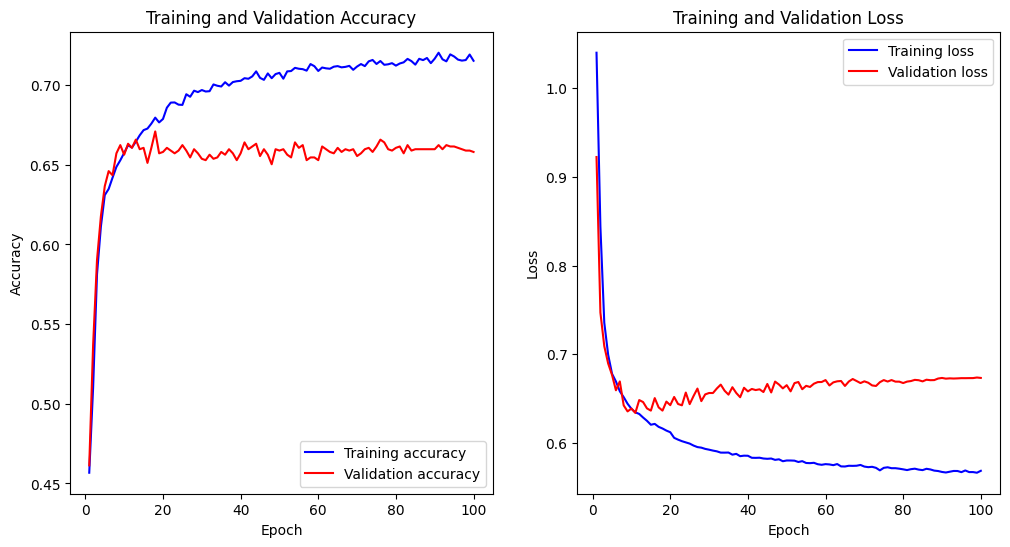

In [ ]:

# Let's create an instance of the main class
itm = ITM_Classifier()
plot_training_history(itm.history)